In [1]:
%matplotlib inline

import math
import time
import numpy as np
import pandas as pd
import pandas_datareader as pdr

import keras
from keras import layers
from keras.models import Sequential

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## Set Parameters

In [3]:
STOCK_INDEX = '^GSPC'

## Getting Data

In [4]:
# get stock price information 
def get_stock_data(index_name, start, end, retry_attempts = 3):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name, start, end)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except Exception  as e:
                print("Caught error {} with {} retry attempts remaining".\
                      format(e, retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None

In [5]:
import datetime

STOCK_INDEX = '^GSPC'

start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2018, 8, 12)

sp_df = get_stock_data(STOCK_INDEX, start, end)

Caught error 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues
 with 3 retry attempts remaining
Caught error 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues
 with 2 retry attempts remaining
Caught error 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues
 with 1 retry attempts remaining


In [16]:
sp_df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000
mean,765.603527,756.378027,761.134672,761.316652,1.268249e+09,761.316652
std,686.190427,679.482449,682.971992,683.082561,1.693406e+09,683.082561
min,63.230000,60.959999,62.279999,62.279999,6.650000e+06,62.279999
25%,131.770000,129.085003,130.339996,130.479996,5.460000e+07,130.479996
50%,462.489990,459.635010,461.274994,461.319992,2.873700e+08,461.319992
75%,1259.910004,1240.719971,1252.437531,1252.049988,2.268122e+09,1252.049988
max,2872.870117,2855.919922,2867.229980,2872.870117,1.145623e+10,2872.870117


In [28]:
sp_df.head(20)

,High,Low,Open,Close,Volume,Adj Close
1970-01-02,93.540001,91.790001,92.059998,93.000000,8050000.0,93.000000
1970-01-03,93.540001,91.790001,92.059998,93.000000,8050000.0,93.000000
1970-01-04,93.540001,91.790001,92.059998,93.000000,8050000.0,93.000000
1970-01-05,94.250000,92.529999,93.000000,93.459999,11490000.0,93.459999
1970-01-06,93.809998,92.129997,93.459999,92.820000,11460000.0,92.820000
1970-01-07,93.379997,91.930000,92.820000,92.629997,10010000.0,92.629997
1970-01-08,93.470001,91.989998,92.629997,92.680000,10670000.0,92.680000
1970-01-09,93.250000,91.820000,92.680000,92.400002,9380000.0,92.400002
1970-01-10,93.250000,91.820000,92.680000,92.400002,9380000.0,92.400002
1970-01-11,93.250000,91.820000,92.680000,92.400002,9380000.0,92.400002


In [56]:
# Prepare data
sp_close = sp_df.Close.resample('W').ffill()
sp_volume = sp_df.Volume.resample('W').mean().ffill()

data = pd.concat([sp_close, sp_volume], axis=1)
data['LogP'] = np.log(data['Close'])
data['LogV'] = np.log(data['Volume'])
data.head(20)

,Close,Volume,LogP,LogV
1970-01-04,93.000000,8.050000e+06,4.532599,15.901183
1970-01-11,92.400002,1.025286e+07,4.526127,16.143067
1970-01-18,90.919998,1.087000e+07,4.509980,16.201517
1970-01-25,89.370003,1.064000e+07,4.492785,16.180131
1970-02-01,85.019997,1.142571e+07,4.442886,16.251377
1970-02-08,86.330002,1.148714e+07,4.458177,16.256739
1970-02-15,86.540001,1.091286e+07,4.460607,16.205452
1970-02-22,88.029999,1.244714e+07,4.477678,16.337002
1970-03-01,89.500000,1.214571e+07,4.494239,16.312487
1970-03-08,89.440002,1.144714e+07,4.493568,16.253251


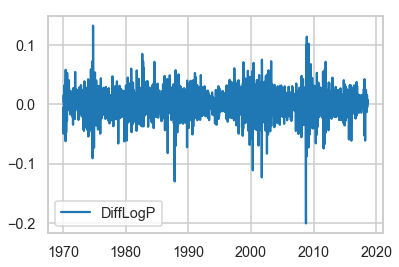

In [156]:
diff_1 = data - data.shift()
diff_1.columns = ["Diff" + s for s in diff_1.columns]
diff_1['DiffAfter1Weeks'] = data.LogP.shift(-1) - data.LogP
diff_1['DiffAfter4Weeks'] = data.LogP.shift(-4) - data.LogP

sp_data = diff_1[['DiffLogP', 'DiffLogV', 'DiffAfter1Weeks']]
sp_data[['DiffLogP']].plot()

## Preprocessing Data

In [157]:
# X is np array and Y is np array
def to_seq(X, y, seq_len = 52):
    sz = len(X)
    new_X = []
    new_y = []
    for i in range(sz - seq_len  + 1):
        new_X.append(X[i:i+seq_len])
        new_y.append(y[i+seq_len-1])
    new_X = np.array(new_X)
    new_y = np.array(new_y)
    return new_X, new_y


def split(X, y, start, end):
    return X[start:end], y[start:end]

In [160]:
print(len(sp_data))
X = sp_data.iloc[1:]
print(X[-10:])
y = (X['DiffAfter1Weeks']>0).values.astype(np.float32)
print(y[-10:])
X = X[['DiffLogP', 'DiffLogV']].values.astype(np.float32)

WINDOW = 52
X, y = to_seq(X, y, seq_len=WINDOW)
print(X.shape)
print(y.shape)


test_size = 52
validation_size = 52
train_size = len(X) - test_size - validation_size

x_train, y_train = split(X, y, 0, train_size)
x_validation, y_validation = split(X, y, train_size, train_size+validation_size)
x_test, y_test = split(X, y, train_size+validation_size, None)


print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

2538
            DiffLogP  DiffLogV  DiffAfter1Weeks
2018-06-17  0.000227  0.246311        -0.008955
2018-06-24 -0.008955 -0.009905        -0.013341
2018-07-01 -0.013341 -0.175476         0.015133
2018-07-08  0.015133 -0.360296         0.014922
2018-07-15  0.014922  0.119744         0.000186
2018-07-22  0.000186  0.104182         0.006046
2018-07-29  0.006046  0.081833         0.007609
2018-08-05  0.007609 -0.024911        -0.002492
2018-08-12 -0.002492 -0.060827        -0.004014
2018-08-19 -0.004014  0.012950              NaN
[0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
(2486, 52, 2)
(2486,)
Data Split Complete
x_train shape=(2382, 52, 2)
y_train shape=(2382,)
x_test shape=(52, 52, 2)
y_test shape=(52,)


## Prepare LSTM Model

In [173]:
def create_model(input_shape):
    model = Sequential()
    
    model.add(layers.Conv1D(16, 5, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv1D(8, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model


In [174]:
model = create_model(x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 48, 16)            176       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 16, 16)            0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 12, 8)             648       
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 8)                 0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total para

## Fit the Model

In [175]:
# use eatrly stopping to avoid overfitting     
lr = 0.0001
optimizer = keras.optimizers.RMSprop(lr=lr)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=4,
                                           verbose=0)]
history = model.fit(x_train, y_train, 
            validation_data = [x_validation, y_validation],
            epochs=100, 
            batch_size=64,
            verbose=2,
            callbacks=callbacks)
print("Model Fit Complete")

Train on 2382 samples, validate on 52 samples
Epoch 1/100
 - 2s - loss: 0.7115 - acc: 0.4899 - val_loss: 0.6904 - val_acc: 0.5385
Epoch 2/100
 - 0s - loss: 0.7030 - acc: 0.5008 - val_loss: 0.6860 - val_acc: 0.5962
Epoch 3/100
 - 0s - loss: 0.7025 - acc: 0.4992 - val_loss: 0.6829 - val_acc: 0.5962
Epoch 4/100
 - 0s - loss: 0.7006 - acc: 0.4954 - val_loss: 0.6808 - val_acc: 0.5962
Epoch 5/100
 - 0s - loss: 0.6975 - acc: 0.5218 - val_loss: 0.6797 - val_acc: 0.5962
Epoch 6/100
 - 0s - loss: 0.6969 - acc: 0.5239 - val_loss: 0.6785 - val_acc: 0.5962
Epoch 7/100
 - 0s - loss: 0.6947 - acc: 0.5344 - val_loss: 0.6780 - val_acc: 0.5962
Epoch 8/100
 - 0s - loss: 0.6943 - acc: 0.5294 - val_loss: 0.6774 - val_acc: 0.5962
Epoch 9/100
 - 0s - loss: 0.6915 - acc: 0.5369 - val_loss: 0.6768 - val_acc: 0.5962
Epoch 10/100
 - 0s - loss: 0.6942 - acc: 0.5361 - val_loss: 0.6768 - val_acc: 0.5962
Epoch 11/100
 - 0s - loss: 0.6921 - acc: 0.5357 - val_loss: 0.6765 - val_acc: 0.5962
Epoch 12/100
 - 0s - loss: 0

## Train Prediction Performance

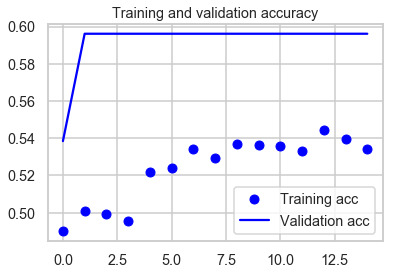

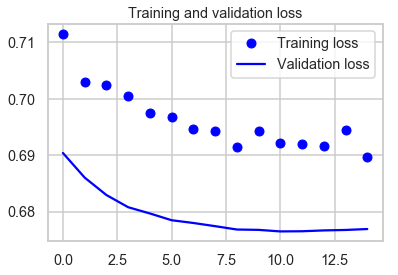

In [176]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [187]:
train_preds = model.predict(x_train).flatten()
print(train_preds)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_preds)

metrics.auc(fpr, tpr)

[0.54572856 0.54200906 0.5453138  ... 0.5756835  0.55543625 0.55916697]


0.4961278451166653

## Test Prediction Performance

In [181]:
test_preds = model.predict(x_test).flatten()


>>> import numpy as np
>>> from sklearn import metrics


print(test_preds.shape, y_test.shape)
test_error = nprmse = math.sqrt(mean_squared_error(y_test, 
                                          test_preds))
print('Test Score: %.2f RMSE' % (test_rmse))
print(test_preds)

(52,) (52,)
Test Score: 0.49 RMSE
[0.55541945 0.5459076  0.55077803 0.55541945 0.54583377 0.5501535
 0.54384923 0.5395795  0.5501535  0.53798485 0.539148   0.5479132
 0.5372674  0.5375399  0.5408975  0.53168213 0.5365723  0.5431171
 0.53420657 0.5365723  0.5431171  0.5382757  0.5454924  0.5431171
 0.5380008  0.55097497 0.54206234 0.53784865 0.55097497 0.5414193
 0.546214   0.5511375  0.5414193  0.546214   0.5511375  0.5447391
 0.546214   0.5500914  0.5423578  0.546214   0.5500914  0.5423578
 0.546214   0.5500914  0.5423578  0.546214   0.5500914  0.5423578
 0.546214   0.5500914  0.5423578  0.546214  ]


## Plot Test Predictions

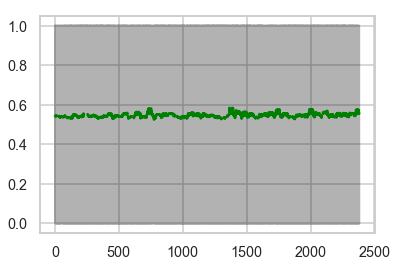

In [180]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

# plot actual data
ax.plot(y_train, 
        label='True Data',
        c='black',alpha=0.3)

# plot flattened data
plt.plot(train_preds,
         label='Prediction_full',
         c='g',linestyle='--')

plt.show()